# Table of Contents

### [1. Preparations](#chapter1)
### [2. Model training](#chapter2)
#### [2.1 TF-IDF](#chapter2.1)
- [Preprocessing](#chapter2.1.1)
- [Train classical statistical models](#chapter2.1.2)
- [Save model results](#chapter2.1.3)
- [Error analysis](#chapter2.1.4)

#### [2.2 LSTM](#chapter2.2)

- [Preprocessing](#chapter2.2.1)
- [Initial modelling](#chapter2.2.2)
- [LSTM with GloVe](#chapter2.2.3)
- [Save model results](#chapter2.2.4)
- [Error analysis](#chapter2.2.5)

#### [2.3 fastText](#chapter2.3)

- [Preprocessing](#chapter2.3.1)
- [Model training](#chapter2.3.2)
- [Save model results](#chapter2.3.3)
- [Error analysis](#chapter2.3.4)

#### [2.4 BERT](#chapter2.4)

- [Preprocessing](#chapter2.4.1)
- [Find the suitable range of learning rates](#chapter2.4.2)
- [Model training](#chapter2.4.3)
- [Save model results](#chapter2.4.4)
- [Error analysis](#chapter2.4.5)

### [3. Summary](#chapter3)

#### [3.1 Analysis of accuracy scores](#chapter3.1)
#### [3.2 Further error analysis](#chapter3.2)

- [Summary of misclassification distribution](#chapter3.2.1)
- [Comparison of absolute error distributions](#chapter3.2.2)
- [Small note on relationship between error and text length](#chapter3.2.3)
- [Inspect misclassified samples of BERT](#chapter3.2.4)

#### [3.3 Conclusion and future works](#chapter3.3)

# 1. Preparations <a class="anchor" id="chapter1"></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings, gc
warnings.filterwarnings("ignore")

# For preprocessings and TF-IDF models
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords
from gensim.matutils import corpus2csc
from gensim import models

from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# For model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# LSTM models
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses
from tensorflow.keras.backend import clear_session

# fastText model
import csv
import fasttext

# BERT model
from transformers import InputExample, InputFeatures
import ktrain

In [ ]:
# Import data that has been preprocessed in "Preprocessing.ipynb"
train_pos = pd.read_csv('Train_pos.csv')
train_neg = pd.read_csv('Train_neg.csv')

test_pos = pd.read_csv('Test_pos.csv')
test_neg = pd.read_csv('Test_neg.csv')

train_df = pd.concat([train_pos, train_neg], ignore_index=True)
test_df = pd.concat([test_pos, test_neg], ignore_index=True)

In [ ]:
# Create dataframe to store results of all models
summary_df = pd.DataFrame(columns=['Model', 'Accuracy'])

# 2. Model training <a class="anchor" id="chapter2"></a>

<hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr>

## <p style="text-align: center;">2.1 TF-IDF <a class="anchor" id="chapter2.1"></a><hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr></p>

### 2.1.1 Preprocessing <a class="anchor" id="chapter2.1.1"></a>

- Remove stopwords

In [ ]:
# Remove stopwords using gensim
train_txt = train_df.Comment.values.tolist()
test_txt = test_df.Comment.values.tolist()
train_no_stopword = [remove_stopwords(text) for text in train_txt]
test_no_stopword = [remove_stopwords(text) for text in test_txt]

- Tokenization

In [ ]:
# Tokenization
train_tokenized = [simple_preprocess(text) for text in train_no_stopword]
test_tokenized = [simple_preprocess(text) for text in test_no_stopword]

- Remove infrequent words

In [ ]:
# Remove infrequent (frequency<50) words in train dataset
frequency = defaultdict(int)
for text in train_tokenized:
    for token in text:
        frequency[token] += 1

train_texts = [
    [token for token in text if frequency[token] > 50]
    for text in train_tokenized
]

# Remove infrequent (frequency<50) words in test dataset
frequency2 = defaultdict(int)
for text in test_tokenized:
    for token in text:
        frequency2[token] += 1

test_texts = [
    [token for token in text if frequency2[token] > 50]
    for text in test_tokenized
]

#### Create TF-IDF model

In [ ]:
all_texts = train_texts + test_texts

# Create a dictionary using all the comments
dictionary = corpora.Dictionary(all_texts)

# Create bag of words
corpus = [dictionary.doc2bow(text) for text in all_texts]

tfidf = models.TfidfModel(corpus)

- Convert TF-IDF results to matrix

In [ ]:
# Number of examples (total)
num_docs = dictionary.num_docs

# Number of unique words
num_terms = len(dictionary.keys())

corpus_tfidf = tfidf[corpus]
corpus_tfidf_sparse = corpus2csc(corpus_tfidf, num_terms=num_terms, num_docs=num_docs)
print('Shape of the matrix from TF-IDF results (combining both train and test):', 
      corpus_tfidf_sparse.shape)

Shape of the matrix from TF-IDF results (combining both train and test): (7685, 50000)


- Transpose* and split sparse matrix into train and test data

<font color=dodgerblue>\*: As output by the previous cell, the sparse matrix has a shape of (number of words) by (number of observations). To make it suitable for model training, the data needs to be in a form of (number of observations) by (number of words).</font>

In [ ]:
X_train = corpus_tfidf_sparse.T[:25000]
X_test = corpus_tfidf_sparse.T[25000:]

### 2.1.2 Train classical statistical models <a class="anchor" id="chapter2.1.2"></a>

#### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, train_df.Sentiment.values)

rf_prediction = rf.predict(X_test)
print(classification_report(test_df.Sentiment.values, rf_prediction))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85     12500
           1       0.86      0.82      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



#### Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, train_df.Sentiment.values)

lr_prediction = lr.predict(X_test)
print(classification_report(test_df.Sentiment.values, lr_prediction))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



### 2.1.3 Save model results <a class="anchor" id="chapter2.1.3"></a>

In [ ]:
rf_accuracy = accuracy_score(test_df.Sentiment.values, rf_prediction)
summary_df = summary_df.append({'Model': 'Random Forest (TF-IDF)', 'Accuracy': rf_accuracy}, ignore_index=True)

In [ ]:
lr_accuracy = accuracy_score(test_df.Sentiment.values, lr_prediction)
summary_df = summary_df.append({'Model': 'Logistic Regression (TF-IDF)', 'Accuracy': lr_accuracy}, ignore_index=True)

### 2.1.4 Error analysis <a class="anchor" id="chapter2.1.4"></a>
**Helper functions**

In [ ]:
def error_analysis(prediction_label, prediction_prob, test_lengths):
    '''
    This function returns a dataframe with needed information for error analysis.
    
    parameters:
        prediction_label (numpy array): predicted labels output by the model
        prediction_prob (numpy array): predicted probabilities output by the model
        test_lengths (list): list of test comments' lengths
    '''
    # Extract the index number of the comments that have been misclassified
    error_index = np.where((test_df.Sentiment.values==prediction_label) == False)[0]

    # Create a subset of the test data that only contains rows that have been
    # misclassified and find the split of these errors regarding their true labels
    error_df = test_df.iloc[error_index]
    print('Distribution of misclassified texts:\n', error_df.Sentiment.value_counts())
    
    # Add a column of the predicted value (the predicted probability instead of the hard label)
    model_df = test_df.copy()
    model_df['Prediction'] = prediction_prob
    
    # Compute the absolute difference between the true label and the predicted probabilitiy
    model_df['Absolute_error'] = model_df.apply(lambda row: abs(row.Prediction-row.Sentiment), axis=1)
    
    # Add column of lengths of texts
    model_df['Text_length'] = test_lengths
    
    return model_df

In [ ]:
def plot_absolute_error(model_df):
    '''
    This function returns two subplots that show the distributions of misclassified and correctly
    classified texts' absolute error values
    
    parameter:
        model_df (pandas DataFrame): a dataframe created from test_df (which contains all
            comments in the test dataset) with additional columns containing the corresponding
            model's probability prediction as well as a calculated field, which is the absolute
            difference between the probability predictions and the true labels
            
    returns:
        Two histogram distribution subplots
    '''
    plt.rcParams["figure.figsize"] = (14,6)
    fig, ax = plt.subplots(1, 2)
    
    # Plot densities of wrongly classified texts' absolute errors
    ax[0].hist(model_df.loc[(model_df.Sentiment==0) & (model_df.Absolute_error>=0.5)].Absolute_error.values, 
               bins=50, 
               alpha=0.5, 
               density=True,
               label='Negative comments')
    ax[0].hist(model_df.loc[(model_df.Sentiment==1) & (model_df.Absolute_error>=0.5)].Absolute_error.values, 
               bins=50, 
               alpha=0.5, 
               density=True,
               label='Positive comments')
    ax[0].legend()
    ax[0].set_xlabel('Absolute error')
    ax[0].set_ylabel('Density')
    ax[0].set_title("Density distribution of misclassified texts' absolute error values")
    
    # Plot densities of correctly classified texts' absolute errors
    ax[1].hist(model_df.loc[(model_df.Sentiment==0) & (model_df.Absolute_error<0.5)].Absolute_error.values, 
               bins=50, 
               alpha=0.5, 
               density=True,
               label='Negative comments')
    ax[1].hist(model_df.loc[(model_df.Sentiment==1) & (model_df.Absolute_error<0.5)].Absolute_error.values, 
               bins=50, 
               alpha=0.5,
               density=True,
               label='Positive comments')
    ax[1].legend()
    ax[1].set_xlabel('Absolute error')
    ax[1].set_ylabel('Density')
    ax[1].set_title("Density distribution of correctly classified texts' absolute error values")
    
    plt.show()

In [ ]:
def plot_length_and_error(model_df):
    '''
    This function returns a scatter plot that shows the relationship between
    text lengths and their predictions' absolute errors
    
    parameter:
        model_df (pandas DataFrame): a dataframe created from test_df (which contains all
            comments in the test dataset) with additional columns containing the corresponding
            model's probability prediction as well as a calculated field, which is the absolute
            difference between the probability predictions and the true labels
    '''
    plt.rcParams["figure.figsize"] = (8,6)

    plt.scatter(model_df.loc[model_df.Sentiment==0].Text_length, 
                model_df.loc[model_df.Sentiment==0].Absolute_error,
                alpha=0.35,
                label='Negative comments')

    plt.scatter(model_df.loc[model_df.Sentiment==1].Text_length, 
                model_df.loc[model_df.Sentiment==1].Absolute_error,
                alpha=0.35,
                label='Positive comments')
    plt.ylabel('Absolute error')
    plt.xlabel('Preprocessed text length')
    plt.title("Relationship between text lengths and their predictions' absolute errors")
    plt.legend()
    plt.show()

- Random Forest Classifier

In [ ]:
rf_df = error_analysis(rf_prediction, 
                       prediction_prob=rf.predict_proba(X_test)[:,1], 
                       test_lengths=[len(text) for text in test_texts])

Distribution of misclassified texts:
 1    2198
0    1663
Name: Sentiment, dtype: int64


**<font color=dodgerblue>Observations:</font>**

<font color=dodgerblue>1. While the test data is balanced in terms of the types of labels, the misclassification of the Random Forest model seems to appear more in positive sentiments.</font>


After gaining an overview of the misclassified texts, we can take a further look by comparing the true labels with the predicted probabilities (instead of the predicted hard labels):

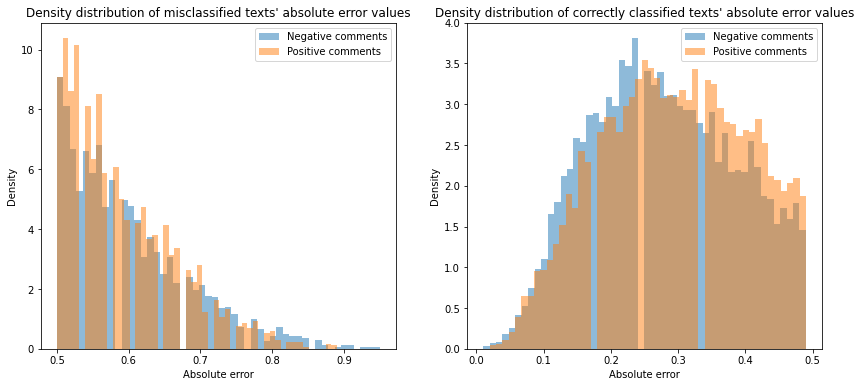

In [ ]:
plot_absolute_error(rf_df)

**<font color=dodgerblue>Observations: (continued)</font>**

<font color=dodgerblue>2. Based on the plot on the left, there is little difference between the distributions of error values between wrongly classified negative texts and wrongly classified positive texts. Meanwhile, the plot on the right suggests that for texts that are labeled correctly, negative comments tend to have slightly more accurate predicted probabilities (i.e., absolute errors are lower) compared to positive ones, as the distribution in blue is slightly more condensed on the left side.</font>

Another perspective of error analysis is by looking at the length of the texts (more specifically, of the preprocessed texts) to see if it has any relationship with their error values:

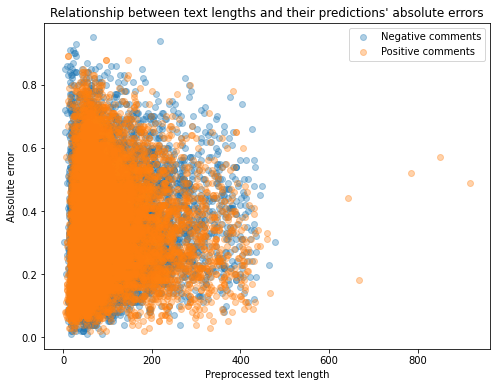

In [ ]:
plot_length_and_error(rf_df)

**<font color=dodgerblue>Observations: (continued)</font>**

<font color=dodgerblue>3. Based on the plot above, we can see little correlation between the text lengths and their predictions' absolute errors.</font>

- Logistic Regression

In [ ]:
lr_df = error_analysis(lr_prediction, 
                       prediction_prob=lr.predict_proba(X_test)[:,1], 
                       test_lengths=[len(text) for text in test_texts])

Distribution of misclassified texts:
 0    1494
1    1485
Name: Sentiment, dtype: int64


**<font color=dodgerblue>Observations:</font>**

<font color=dodgerblue>1. The misclassification seems very balanced between the two classes.</font>


After gaining an overview of the misclassified texts, we can take a further look by comparing the true labels with the predicted probabilities (instead of the predicted hard labels):

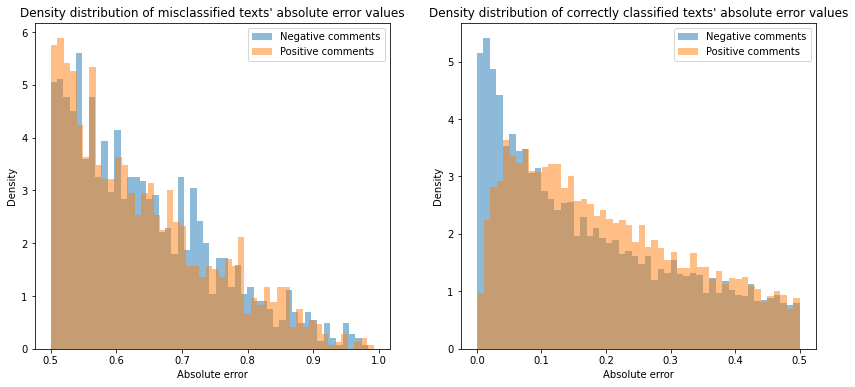

In [ ]:
plot_absolute_error(lr_df)

**<font color=dodgerblue>Observations: (continued)</font>**

<font color=dodgerblue>2. Based on the plot on the left, there is little difference between the distributions of error values between wrongly classified negative texts and wrongly classified positive texts. Meanwhile, the plot on the right suggests that for texts that are labeled correctly, negative comments tend to have more accurate predicted probabilities (i.e., absolute errors are lower) compared to positive ones, as the distribution in blue is more condensed on the left side.\
Based on these two plots, it appears that Logistic Regression has better performance, as all distributions are more condensed on the left side of the plot (i.e., for all its predictions the absolute errors are relatively low) especially when compared to Random Forest, which is also consistent with the accuracy results.</font>

Another perspective of error analysis is by looking at the length of the texts (more specifically, of the preprocessed texts) to see if it has any relationship with their error values:

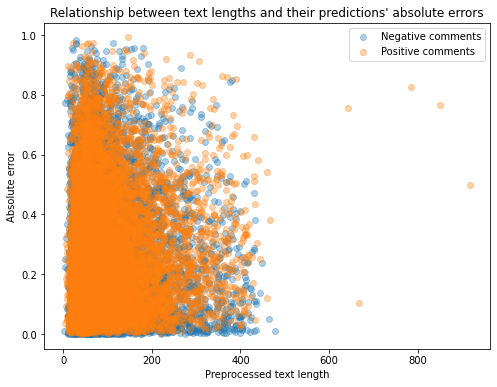

In [ ]:
plot_length_and_error(lr_df)

**<font color=dodgerblue>Observations: (continued)</font>**

<font color=dodgerblue>3. Based on the plot above, we can see little correlation between the text lengths and their predictions' absolute errors.</font>

<hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr>

## <p style="text-align: center;">2.2 LSTM <a class="anchor" id="chapter2.2"></a><hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr></p>

**Helper function**

In [ ]:
def plot_history(history):
    '''
    This function returns two subplots that show the compiling history of the neural network
    
    parameter:
        history (keras.callbacks.History): compiling history of the trained model
            
    returns:
        Two line subplots
    '''
    plt.rcParams["figure.figsize"] = (14,6)
    fig, ax = plt.subplots(1, 2)
    
    # Plot changes in loss values
    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    epochs = range(1, len(loss_values)+1)

    ax[0].plot(epochs, loss_values, label='Training Loss')
    ax[0].plot(epochs, val_loss_values, label='Validation Loss')
    ax[0].legend()
    ax[0].set_title('Compiling history of model')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    
    # Plot changes in loss values
    acc_values = history.history['accuracy']
    val_acc_values = history.history['val_accuracy']
    epochs = range(1, len(acc_values)+1)

    ax[1].plot(epochs, acc_values, label='Training Accuracy')
    ax[1].plot(epochs, val_acc_values, label='Validation Accuracy')
    ax[1].legend()
    ax[1].set_title('Compiling history of model')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    
    plt.show()

### 2.2.1 Preprocessing <a class="anchor" id="chapter2.2.1"></a>
**(Note: the first few steps are the same as the preprocessing steps in the TF-IDF part above.)**

- Remove stopwords

In [ ]:
# Remove stopwords using gensim
train_txt = train_df.Comment.values.tolist()
test_txt = test_df.Comment.values.tolist()
train_no_stopword = [remove_stopwords(text) for text in train_txt]
test_no_stopword = [remove_stopwords(text) for text in test_txt]

- Tokenization

In [ ]:
# Tokenization
train_tokenized = [simple_preprocess(text) for text in train_no_stopword]
test_tokenized = [simple_preprocess(text) for text in test_no_stopword]

- Remove infrequent words

In [ ]:
# Remove infrequent (frequency<50) words in train dataset
frequency = defaultdict(int)
for text in train_tokenized:
    for token in text:
        frequency[token] += 1

train_texts = [
    [token for token in text if frequency[token] > 50]
    for text in train_tokenized
]

# Remove infrequent (frequency<50) words in test dataset
frequency2 = defaultdict(int)
for text in test_tokenized:
    for token in text:
        frequency2[token] += 1

test_texts = [
    [token for token in text if frequency2[token] > 50]
    for text in test_tokenized
]

all_texts = train_texts + test_texts

In [ ]:
# Create an instance object of the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)

total_words = len(tokenizer.word_index)

In [ ]:
# Iterate through the list of comments; For each text, use the tokenizer
# to encode it into a sequence of numbers (word indices)
input_sequences = [tokenizer.texts_to_sequences([line])[0] for line in all_texts]

# Determine the largest length of all texts
max_sequence_len = max([len(x) for x in input_sequences]) 
print('The longest text has %d words' %max_sequence_len)

The longest text has 929 words


Considering that the longest Comment is very likely to be an outlier (in terms of its length), it is unreasonable to strictly use its length for padding the remaining sequence in order to preserve all the texts. Instead, to reduce computing time, the maximum sequence length will be redefined (i.e., "trimmed") as shown below:

In [ ]:
# Redefine max_sequence_len
max_sequence_len = 250

# Pad sequences
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen=max_sequence_len, 
                                         padding='post'))

print('Shape of the preprocessed sequences (combining both train and test):', 
      np.shape(input_sequences))

Shape of the preprocessed sequences (combining both train and test): (50000, 250)


In [ ]:
X_train = input_sequences[:25000]
X_test = input_sequences[25000:]

y_train = train_df.Sentiment.values
y_test = test_df.Sentiment.values

### 2.2.2 Initial modelling <a class="anchor" id="chapter2.2.2"></a>

In [ ]:
lstm_size = 100
embedding_size = 80
dropout_rate = 0.4

EPOCHS = 50
BATCH_SIZE = 25

In [ ]:
tf.compat.v1.reset_default_graph()
clear_session()

input_layer = Input(shape=(max_sequence_len))

# The embedding layer here converts the words into vectors.
# Here, since the comments have ben padded, the total
# "vocabulary size" will be the number of words plus 1 (the
# additional "word" is the 0's used in padding). Also due to
# the padding, the mask_zero parameter should be set as True.
embed_layer = Embedding(input_dim=total_words+1,
                        output_dim=embedding_size, 
                        input_length=max_sequence_len,
                        mask_zero=True)(input_layer)

lstm_layer1 = LSTM(lstm_size, return_sequences=True)(embed_layer)
dropout_layer = Dropout(dropout_rate)(lstm_layer1)
lstm_layer2 = LSTM(lstm_size)(dropout_layer)

# Since we need to output a probability (of the text being positive)
# which is between 0 and 1
output = Dense(1, activation='sigmoid')(lstm_layer2)

lstm_1 = Model(inputs=input_layer, outputs=output)
lstm_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 80)           614880    
                                                                 
 lstm (LSTM)                 (None, 250, 100)          72400     
                                                                 
 dropout (Dropout)           (None, 250, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 767,781
Trainable params: 767,781
Non-trainable

In [ ]:
# Loss (since it's a binary classification problem)
loss = losses.BinaryCrossentropy()

# Optimizer
optimizer = RMSprop(learning_rate=0.00005)

# Compilation
lstm_1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', 
                   verbose=1, patience=5)

lstm_history1 = lstm_1.fit(X_train, y_train,
                           validation_data=(X_test, y_test),
                           epochs=EPOCHS,
                           batch_size=BATCH_SIZE,
                           callbacks=es)

Epoch 1/50
1000/1000 [==============================] - 38s 30ms/step - loss: 0.5479 - accuracy: 0.7110 - val_loss: 0.4011 - val_accuracy: 0.8256
Epoch 2/50
1000/1000 [==============================] - 29s 29ms/step - loss: 0.3283 - accuracy: 0.8633 - val_loss: 0.3298 - val_accuracy: 0.8590
Epoch 3/50
1000/1000 [==============================] - 29s 29ms/step - loss: 0.2672 - accuracy: 0.8930 - val_loss: 0.3143 - val_accuracy: 0.8699
Epoch 4/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.2391 - accuracy: 0.9072 - val_loss: 0.3025 - val_accuracy: 0.8734
Epoch 5/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.2218 - accuracy: 0.9134 - val_loss: 0.3053 - val_accuracy: 0.8738
Epoch 6/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.2098 - accuracy: 0.9200 - val_loss: 0.3030 - val_accuracy: 0.8744
Epoch 7/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.2020 - accuracy: 0.9222 - val_loss: 0.3032 -

In [ ]:
lstm_prediction1 = lstm_1.predict(X_test)
lstm_prediction1 = [1 if p>0.5 else 0 for p in lstm_prediction1]

print(classification_report(test_df.Sentiment.values, lstm_prediction1))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87     12500
           1       0.89      0.84      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



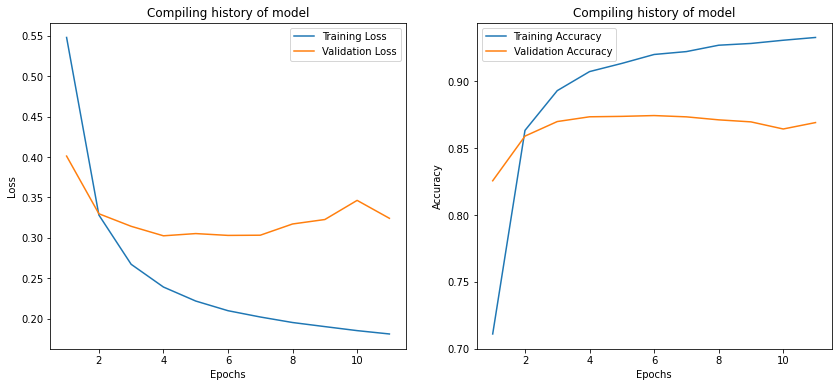

In [ ]:
plot_history(lstm_history1)

<font color=dodgerblue>**Summary:**</font>

<font color=dodgerblue>After experimenting with various parameter combinations, the one shown here is one of the best. An interesting point worth raising is that while the maximum sequence length has been cut down to 250 here, other sizes have also been experimented, and it appears that **using a larger maximum sequence length does not seem to improve the model** (which is another reason for limiting the sequence length). This could be because of the limitation of the LSTM's capacity--given that the cell state needs to discard certain information every time it goes in the new "time step" (in this project probably "word" would be more accurate), it cannot gain much from having a longer input sequence.\
By adding Dropout layers and Early Stopping, as shown in the two plots above, the model does not show too much overfitting and is relatively robust.</font>

<font color=dodgerblue>**- Model performance**: When measured in accuracy score, the model's performance does not seem to show much improvement compared to the much more "basic" models shown above (although further analysis in the following section would suggest something different.)</font>

### 2.2.3 LSTM with GloVe <a class="anchor" id="chapter2.2.3"></a>

In [ ]:
# Extract the embeddings from GloVe
with open('glove.6B.300d.txt', 'r', encoding='UTF-8') as f:
    word_to_vec_map = {}
    for line in f:
        w_line = line.split()
        curr_word = w_line[0]
        word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)

# Size of the GloVe embeddings
embedding_dim = len(word_to_vec_map['the'])

In [ ]:
words_to_index = tokenizer.word_index
emb_matrix = np.zeros((total_words+1, embedding_dim))

# Create an embedding matrix based on the unique words in all comments (which is
# stored in the words_to_index variable) and the embeddings provided by the GloVe
# file above
for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index] = embedding_vector

del word_to_vec_map

In [ ]:
lstm_size = 100
dropout_rate = 0.4

EPOCHS = 100
BATCH_SIZE = 25

In [ ]:
tf.compat.v1.reset_default_graph()
clear_session()

input_layer = Input(shape=(max_sequence_len))

# Create an embedding layer using the embedding matrix defined above
# Note: since the GloVe embeddings have already been pretrained, the
# trainable parameter here will be False
embed_layer = Embedding(input_dim=total_words+1,
                        output_dim=embedding_dim,
                        input_length=max_sequence_len,
                        weights = [emb_matrix],
                        trainable=False)(input_layer)

lstm_layer1 = LSTM(lstm_size, return_sequences=True)(embed_layer)
dropout_layer_1 = Dropout(dropout_rate)(lstm_layer1)

lstm_layer2 = LSTM(lstm_size)(dropout_layer_1)
dropout_layer2 = Dropout(dropout_rate)(lstm_layer2)

output = Dense(1, activation='sigmoid')(dropout_layer2)

lstm_2 = Model(inputs=input_layer, outputs=output)
lstm_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 300)          2305800   
                                                                 
 lstm (LSTM)                 (None, 250, 100)          160400    
                                                                 
 dropout (Dropout)           (None, 250, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101   

In [ ]:
# Loss
loss = losses.BinaryCrossentropy()

# Optimizer
optimizer = RMSprop(learning_rate=0.00002)

# Compilation
lstm_2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', 
                   verbose=1, patience=10)

lstm_history2 = lstm_2.fit(X_train, y_train,
                           validation_data=(X_test, y_test),
                           epochs=EPOCHS,
                           batch_size=BATCH_SIZE,
                           callbacks=es)

Epoch 1/100
1000/1000 [==============================] - 48s 45ms/step - loss: 0.6926 - accuracy: 0.5037 - val_loss: 0.6923 - val_accuracy: 0.5048
Epoch 2/100
1000/1000 [==============================] - 48s 48ms/step - loss: 0.6913 - accuracy: 0.5116 - val_loss: 0.6903 - val_accuracy: 0.5134
Epoch 3/100
1000/1000 [==============================] - 48s 48ms/step - loss: 0.6844 - accuracy: 0.5316 - val_loss: 0.6400 - val_accuracy: 0.7138
Epoch 4/100
1000/1000 [==============================] - 44s 44ms/step - loss: 0.5793 - accuracy: 0.7357 - val_loss: 0.5541 - val_accuracy: 0.7513
Epoch 5/100
1000/1000 [==============================] - 44s 44ms/step - loss: 0.5355 - accuracy: 0.7670 - val_loss: 0.5238 - val_accuracy: 0.7739
Epoch 6/100
1000/1000 [==============================] - 44s 44ms/step - loss: 0.5111 - accuracy: 0.7849 - val_loss: 0.4987 - val_accuracy: 0.7877
Epoch 7/100
1000/1000 [==============================] - 44s 44ms/step - loss: 0.4807 - accuracy: 0.8029 - val_loss: 0

In [ ]:
lstm_prediction2 = lstm_2.predict(X_test)
lstm_prediction2 = [1 if p>0.5 else 0 for p in lstm_prediction2]
print(classification_report(y_test, lstm_prediction2))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     12500
           1       0.88      0.84      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



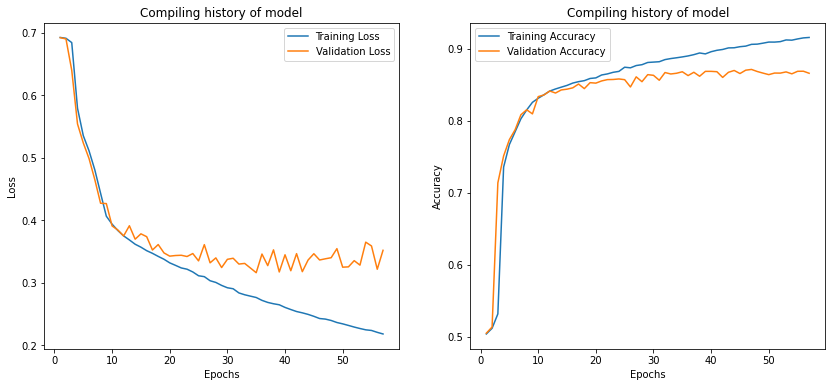

In [ ]:
plot_history(lstm_history2)

<font color=dodgerblue>**Summary:**</font>

<font color=dodgerblue>After experimenting with various parameter combinations, the one shown here is one of the best. By adding Dropout layers and Early Stopping, as shown in the two plots above, the model does not show much overfitting and is relatively robust.\
Another relevant (and not surprising) observation is that **when a higher dimension of the GloVe embedding is used, the model would gain a better performance**. This is reasonable because by using a larger embedding size, the embedding vectors are able to capture more aspects of the differences/similarities among the words and thus benefit the model training.</font>

<font color=dodgerblue>**- Model performance**: When measured in accuracy score, the model's performance does not seem to show much improvement compared to the much more "basic" models shown above (although further analysis in the following section would suggest something different.)</font>

### 2.2.4 Save model results <a class="anchor" id="chapter2.2.4"></a>

In [ ]:
lstm_accuracy1 = accuracy_score(test_df.Sentiment.values, lstm_prediction1)
summary_df = summary_df.append({'Model': 'LSTM (Initial)', 'Accuracy': lstm_accuracy1}, ignore_index=True)

In [ ]:
lstm_accuracy2 = accuracy_score(test_df.Sentiment.values, lstm_prediction2)
summary_df = summary_df.append({'Model': 'LSTM (GloVe embedding)', 'Accuracy': lstm_accuracy2}, ignore_index=True)

### 2.2.5 Error analysis <a class="anchor" id="chapter2.2.5"></a>

- LSTM (Plain)

In [ ]:
lstm_df1 = error_analysis(lstm_prediction1, 
                          prediction_prob=lstm_1.predict(X_test), 
                          test_lengths=[len(text) for text in test_texts])

Distribution of misclassified texts:
 1    1982
0    1290
Name: Sentiment, dtype: int64


**<font color=dodgerblue>Observations:</font>**

<font color=dodgerblue>1. The misclassification seems to be more concentrated in positive comments.</font>


After gaining an overview of the misclassified texts, we can take a further look by comparing the true labels with the predicted probabilities (instead of the predicted hard labels):

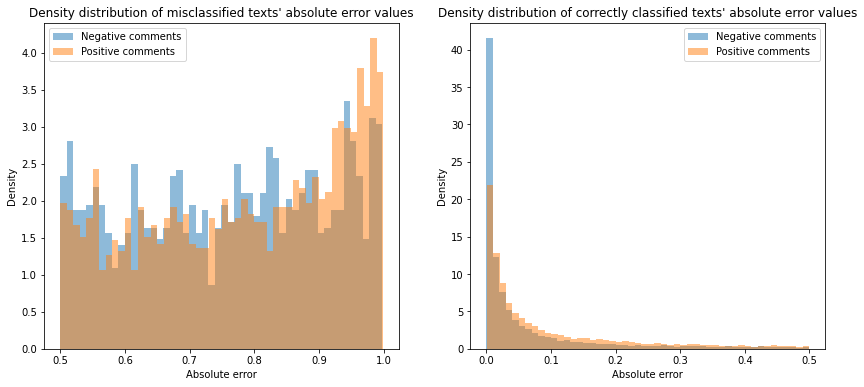

In [ ]:
plot_absolute_error(lstm_df1)

**<font color=dodgerblue>Observations: (continued)</font>**

<font color=dodgerblue>2. Both histogram plots show that the distributions of absolute errors are very similar for negative and positive comments, with the performance on negative comments being slightly better (i.e., having its distribution more concentrated on the left side of the graph.) Meanwhile, it is worth noting that the LSTM model seems to perform very well whenever a text is correctly classified--as shown in the second plot, the texts that are correctly labeled mostly have a very low absolute error (i.e., the model has very high confidence when predicting a text correctly.) This observation has a very strong contrast with especially the two models above (Logistic Regression and Random Forest), which proves that **by using a more complex model structure, while the accuracy results have not improved, the underlying predictions have actually become better**.</font>

Another perspective of error analysis is by looking at the length of the texts (more specifically, of the preprocessed texts) to see if it has any relationship with their error values:

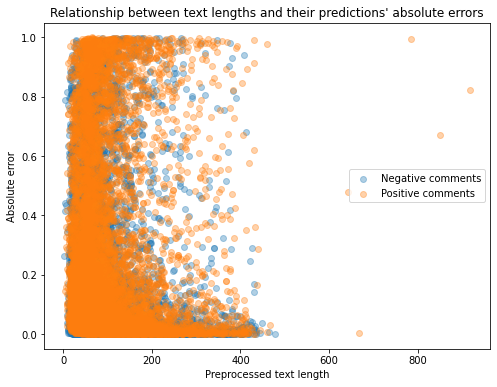

In [ ]:
plot_length_and_error(lstm_df1)

**<font color=dodgerblue>Observations: (continued)</font>**

<font color=dodgerblue>3. Based on the plot above, we can see little correlation between the text lengths and their predictions' absolute errors.</font>

- LSTM (with GloVe embedding)

In [ ]:
lstm_df2 = error_analysis(lstm_prediction2, 
                          prediction_prob=lstm_2.predict(X_test), 
                          test_lengths=[len(text) for text in test_texts])

Distribution of misclassified texts:
 1    1956
0    1390
Name: Sentiment, dtype: int64


**<font color=dodgerblue>Observations:</font>**

<font color=dodgerblue>1. The misclassification seems to be more concentrated in negative comments, which is the opposite of the case of the plain LSTM above.</font>


After gaining an overview of the misclassified texts, we can take a further look by comparing the true labels with the predicted probabilities (instead of the predicted hard labels):

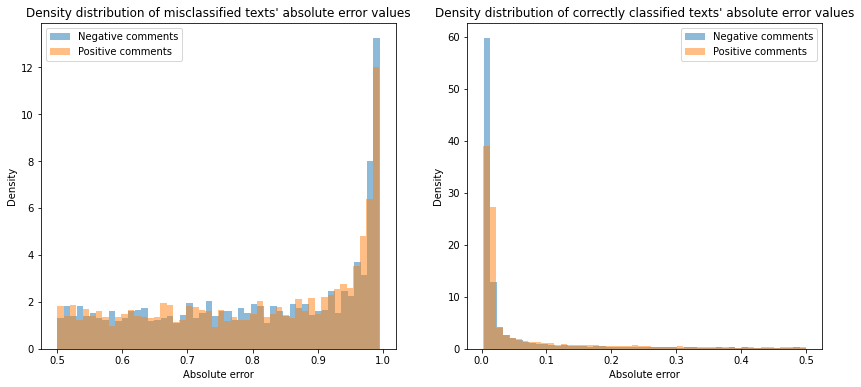

In [ ]:
plot_absolute_error(lstm_df2)

**<font color=dodgerblue>Observations: (continued)</font>**

<font color=dodgerblue>2. The plot on the left shows that the distributions of absolute errors are very similar for negative and positive comments, with the performance on negative comments being slightly worse (i.e., having its distribution more concentrated on the right side of the graph.) Meanwhile, the plot on the right suggests something different: the absolute errors on negative texts are slightly lower than those on positive ones.\
Moreover, similar to the plain LSTM above, when using the pre-trained embeddings, the model seems to perform very well whenever a text is correctly classified--as shown in the second plot. At the same time, when comparing both LSTMs' plots on the left, it seems that the one with GloVe embeddings has a much more skewed distribution of errors on misclassified observations, i.e., the GloVe-embedding model makes more "severe" mistakes once it misclassifies a text.\
Again, this observation has a very strong contrast with the two TF-IDF models above, which suggests an improvement in predictions when a more complex model structure is used.</font>

Another perspective of error analysis is by looking at the length of the texts (more specifically, of the preprocessed texts) to see if it has any relationship with their error values:

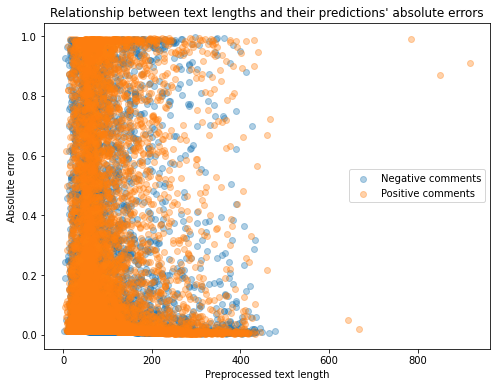

In [ ]:
plot_length_and_error(lstm_df2)

**<font color=dodgerblue>Observations: (continued)</font>**

<font color=dodgerblue>3. Based on the plot above, we can see little correlation between the text lengths and their predictions' absolute errors.</font>

<hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr>

## <p style="text-align: center;">2.3 fastText <a class="anchor" id="chapter2.3"></a><hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr></p>

### 2.3.1 Preprocessing <a class="anchor" id="chapter2.3.1"></a>

In [ ]:
train_copy = train_df.copy()
test_copy = test_df.copy()

train_copy['Comment'] = train_copy.apply(lambda x: remove_stopwords(x.Comment), axis=1)
test_copy['Comment'] = test_copy.apply(lambda x: remove_stopwords(x.Comment), axis=1)

train_copy.iloc[:, 0] = train_copy.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))
test_copy.iloc[:, 0] = test_copy.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))

# Prefixing each row of the category column with '__label__' (required format for the model)
train_copy.iloc[:, 1] = train_copy.iloc[:, 1].apply(lambda x: '__label__' + str(x))
test_copy.iloc[:, 1] = test_copy.iloc[:, 1].apply(lambda x: '__label__' + str(x))

In [ ]:
train_copy[['Comment', 'Sentiment']].to_csv('train.txt', 
                                           index=False, 
                                           sep = ' ',
                                           header = None, 
                                           quoting = csv.QUOTE_NONE, 
                                           quotechar = "", 
                                           escapechar = " ")

test_copy[['Comment', 'Sentiment']].to_csv('test.txt', 
                                           index=False, 
                                           sep = ' ',
                                           header = None, 
                                           quoting = csv.QUOTE_NONE, 
                                           quotechar = "", 
                                           escapechar = " ")

### 2.3.2 Model training <a class="anchor" id="chapter2.3.2"></a>

In [ ]:
fasttext_model = fasttext.train_supervised(input="train.txt", epoch=20, lr=0.1, wordNgrams=3, dim=80)

# Predicted probability
fasttext_pred = fasttext_model.predict(test_copy.Comment.tolist(), k=2)
fasttext_prob = []
for i in range(len(test_copy)):
    if fasttext_pred[0][i][0] == '__label__1':
        fasttext_prob.append(fasttext_pred[1][i][0])
    else:
        fasttext_prob.append(1-fasttext_pred[1][i][0])

# Predicted label
fasttext_label = [1 if p>0.5 else 0 for p in fasttext_prob]

### 2.3.3 Save model results <a class="anchor" id="chapter2.3.3"></a>

In [ ]:
fasttext_acc = accuracy_score(test_df.Sentiment.values, fasttext_label)
summary_df = summary_df.append({'Model': 'fastText', 'Accuracy': fasttext_acc}, ignore_index=True)

### 2.3.4 Error analysis <a class="anchor" id="chapter2.3.4"></a>

In [ ]:
fasttext_df = error_analysis(fasttext_label, 
                             prediction_prob=fasttext_prob,
                             test_lengths=[len(text) for text in test_tokenized])

Distribution of misclassified texts:
 1    1482
0    1406
Name: Sentiment, dtype: int64


**<font color=dodgerblue>Observations:</font>**

<font color=dodgerblue>1. The misclassification seems to be balanced between the two types of sentiments.</font>


After gaining an overview of the misclassified texts, we can take a further look by comparing the true labels with the predicted probabilities (instead of the predicted hard labels):

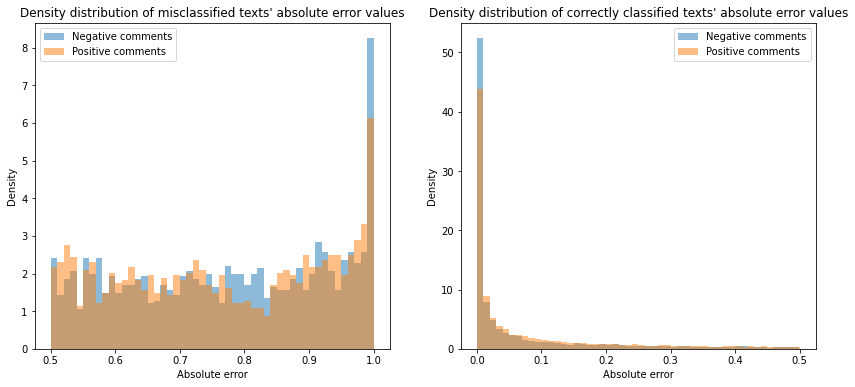

In [ ]:
plot_absolute_error(fasttext_df)

**<font color=dodgerblue>Observations: (continued)</font>**

<font color=dodgerblue>2. The two plots above are similar to the ones of the LSTM model with GloVe embeddings with two main differences: 1) The skewness of the distribution on the first plot (i.e., the distribution of the absolute error on misclassified texts) is smaller; 2) The differences between negative and positive comments' error distribution is also lower. This means that the fastText model is able to perform very well whenever a text is correctly classified--as shown in the second plot, while it still tends to make more "severe" mistakes once it misclassifies a text (but less severe compared to LSTM with GloVe embeddings.) </font>

Another perspective of error analysis is by looking at the length of the texts (more specifically, of the preprocessed texts) to see if it has any relationship with their error values:

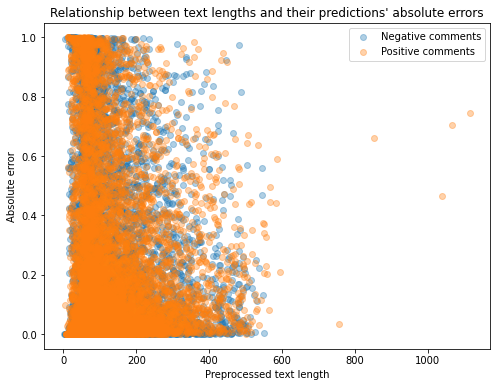

In [ ]:
plot_length_and_error(fasttext_df)

**<font color=dodgerblue>Observations: (continued)</font>**

<font color=dodgerblue>3. Based on the plot above, we can see little correlation between the text lengths and their predictions' absolute errors.</font>

<hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr>

## <p style="text-align: center;">2.4 BERT <a class="anchor" id="chapter2.4"></a><hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr></p>

### 2.4.1 Preprocessing <a class="anchor" id="chapter2.4.1"></a>

In [ ]:
max_len = 250
batch_size = 6

In [ ]:
# Transformer Model
bert = ktrain.text.Transformer('bert-base-uncased', maxlen=max_len, classes = [0,1])

X_train = train_df['Comment'].tolist()
y_train = train_df['Sentiment'].tolist()

X_test = test_df['Comment'].tolist()
y_test = test_df['Sentiment'].tolist()

# Pre-processing training & test data
train = bert.preprocess_train(X_train,y_train)
test = bert.preprocess_test(X_test,y_test)

model = bert.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=test, batch_size=batch_size)

preprocessing train...
language: en
train sequence lengths:
	mean : 113
	95percentile : 294
	99percentile : 440


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 226
	95percentile : 576
	99percentile : 889


### 2.4.2 Find the suitable range of learning rates <a class="anchor" id="chapter2.4.2"></a>

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
4166/4166 [==============================] - 1997s 474ms/step - loss: 0.4863 - accuracy: 0.7499
Epoch 2/5
4166/4166 [==============================] - 2068s 496ms/step - loss: 0.3016 - accuracy: 0.8761
Epoch 3/5
4166/4166 [==============================] - 2071s 497ms/step - loss: 0.7213 - accuracy: 0.5085
Epoch 4/5
4166/4166 [==============================] - 573s 137ms/step - loss: 1.1356 - accuracy: 0.5006


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


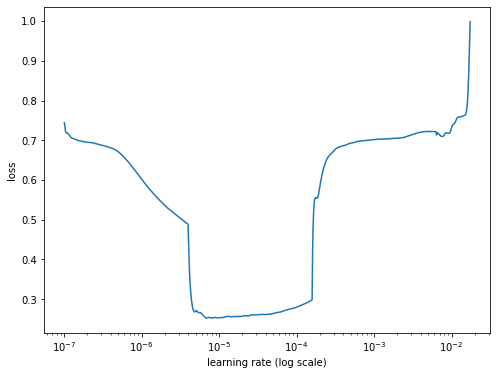

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)

learner.lr_find(max_epochs=5)
learner.lr_plot()

The plot above suggests that setting the learning rate in the range between 7e-6 and 5e-5 would be better since it has the lowest loss.

### 2.4.3 Model training <a class="anchor" id="chapter2.4.3"></a>

In [ ]:
learning_rate = 7e-6
epochs = 5
learner.fit_onecycle(learning_rate, epochs)

# Results summary
x = learner.validate(class_names=bert.get_classes())



begin training using onecycle policy with max lr of 7e-06...
Epoch 1/5
4167/4167 [==============================] - 2466s 587ms/step - loss: 0.3533 - accuracy: 0.8462 - val_loss: 0.2238 - val_accuracy: 0.9116
Epoch 2/5
4167/4167 [==============================] - 2514s 603ms/step - loss: 0.2108 - accuracy: 0.9179 - val_loss: 0.2368 - val_accuracy: 0.9074
Epoch 3/5
4167/4167 [==============================] - 2508s 601ms/step - loss: 0.1510 - accuracy: 0.9450 - val_loss: 0.2255 - val_accuracy: 0.9194
Epoch 4/5
4167/4167 [==============================] - 2507s 601ms/step - loss: 0.0771 - accuracy: 0.9746 - val_loss: 0.2592 - val_accuracy: 0.9216
Epoch 5/5
4167/4167 [==============================] - 2498s 599ms/step - loss: 0.0352 - accuracy: 0.9908 - val_loss: 0.2805 - val_accuracy: 0.9230
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     12500
           1       0.92      0.93      0.92     12500

    accuracy                     

### 2.4.4 Save model results <a class="anchor" id="chapter2.4.4"></a>

In [ ]:
# Model predictions
bert_pred = learner.predict(test)
bert_prob = [p[1] for p in bert_pred]
bert_label = [1 if p>0.5 else 0 for p in bert_prob]

bert_accuracy = accuracy_score(test_df.Sentiment.values, bert_label)
summary_df = summary_df.append({'Model': 'BERT', 'Accuracy': bert_accuracy}, ignore_index=True)

### 2.4.5 Error analysis <a class="anchor" id="chapter2.4.5"></a>

In [ ]:
bert_df = error_analysis(bert_label, 
                         prediction_prob=bert_prob,
                         test_lengths=[len(text) for text in test_tokenized])

Distribution of misclassified texts:
 0    1068
1     857
Name: Sentiment, dtype: int64


**<font color=dodgerblue>Observations:</font>**

<font color=dodgerblue>1. The BERT model seems to have fewer misclassifications in positive comments.</font>


After gaining an overview of the misclassified texts, we can take a further look by comparing the true labels with the predicted probabilities (instead of the predicted hard labels):

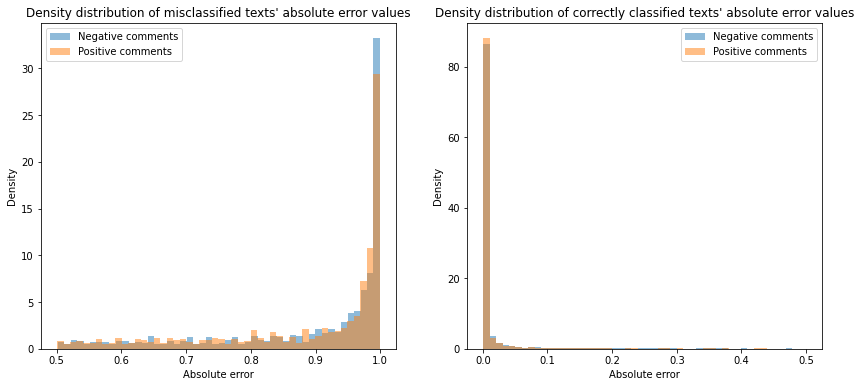

In [ ]:
plot_absolute_error(bert_df)

**<font color=dodgerblue>Observations: (continued)</font>**

<font color=dodgerblue>2. The plot on the left shows that the BERT model performs slightly better in positive comments whenever it misclassifies (i.e., the positive comments tend to have a smaller absolute error.) This plot also shows that overall, when the model misclassifies, it tends to make more "severe" mistakes (with a large density on the right side of the plot.)\
The plot on the right shows that for texts that are correctly labeled, the model is able to predict with very high confidence.</font>

Another perspective of error analysis is by looking at the length of the texts (more specifically, of the preprocessed texts) to see if it has any relationship with their error values:

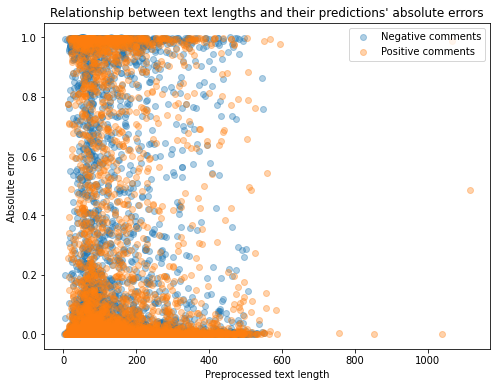

In [ ]:
plot_length_and_error(bert_df)

**<font color=dodgerblue>Observations: (continued)</font>**

<font color=dodgerblue>3. Based on the plot above, again, we can see little correlation between the text lengths and their predictions' absolute errors.</font>

# 3. Summary <a class="anchor" id="chapter3"></a>

## 3.1 Analysis of accuracy scores <a class="anchor" id="chapter3.1"></a>

In [ ]:
summary_df.sort_values('Accuracy', ascending=False)

,Model,Accuracy
5,BERT,0.92300
4,fastText,0.88448
1,Logistic Regression (TF-IDF),0.88084
2,LSTM (Initial),0.86912
3,LSTM (GloVe embedding),0.86616
0,Random Forest (TF-IDF),0.84556


**<font color=dodgerblue>Analysis:</font>**

<font color=dodgerblue>1. Based on the summary table above, **BERT appears to outperform all other models** with an accuracy score on validation data of 92.3%, which is not surprising given that the model is much more complex and that it has already been pre-trained.<br><br/>
    2. The performance of the fastText model and TF-IDF Logistic Regression are very close to each other. This could be because **both models have used Bag of Words**. One possible explanation for fastText's slightly higher accuracy could be because of **its "wordNgrams" feature**, which allows the model to consider local word order and add some more context.<br><br/>
    3. While TF-IDF models are the simpliest ones among all, they have shown very good performance, especially using Logistic Regression, which has a better performance in terms of accuracy when compared to LSTMs.<br><br/>
This can be partly explained by the structure of the models. Since the goal is to classify sentiment, the sentence structure itself does not matter. Instead of focusing on analysing the sentences themselves, **often times the specific words and their frequency used in the comments can tell much more about the sentiment**. With the TF-IDF matrices as training data, which is created by summarizing all the words' occurence within and across different texts, even a relatively simple model can learn from the somehow explicit relationship between the texts' sentiments and certain words' occurrence frequency and therefore achieve such high accuracy. For example, the model might learn that when the second word in the dictionary has a high score assigned by TF-IDF, the text is mostly positive.<br><br/>
    In comparison, **the LSTM models focuses more on the sequence of the texts themselves**. Even though the models also use an embedding layer that represents words with vectors and therefore also enables the models to learn the relationship between the words and the texts' sentiments, such a relationship is more implicit when compared to the TF-IDF models as mentioned above. While LSTMs have much more complex structures, much of its capacity is used in finding out the relationship between the sentences' sequence and their underlying sentiment, and as pointed out earlier, the sequence of the structure of the sentence itself often aren't as effective as the word usage and frequency when it comes to classifying sentiments. Therefore, with enough capacity and model complexity, it is reasonable to assume that LSTM can outperform TF-IDF model by considering both the words used and the sentences themselves. However, due to the constraint in resources, this cannot be proved yet.<br><br/>
    4. **The two LSTM models have very similar performance in terms of accuracy**, which is unexpected, for one might assume that using pre-trained word embeddings from GloVe can improve the results. However, given that the accuracy difference is so small between the two models, **the underperformance of the GloVe embedded LSTM could be because of the model parameters**--it is possible that the GloVe embedded LSTM does not perform as well as it should be because the suitable structure/optimizer/learning rate has not been found yet. <br><br/>
    Apart from the accuracy comparison, one can also view the difference between the two LSTMs by looking at their compiling history plots. It appears that **the LSTM without any pre-trained embeddings has shown more overfitting**, and that its validation accuracy has been at first higher than the training accuracy and was later surpassed. In comparison, **the LSTM with the GloVe embeddings shows more steady changes in the accuracy scores of training and validation data**--the validation accuracy increased with the increase in training accuracy. This might indicate that the model parameters of the LSTM without any pre-trained embeddings might be more "suitable" (in terms of predicting validation dataset) than the ones of the GloVe LSTM.<br><br/>
    5. Another point worth noticing is **the difference between the two TF-IDF models**. With the same preprocessed data derived from TF-IDF, the Logistic Regression model appears to have much better performance than Random Forest. One possible explanation is that due to the large number of "variable numbers" (which is essentially the number of unique words, for they represent the number of columns in the TF-IDF preprocessed matrices), **it is more difficult for Random Forest to fit the data with similar capacity**. In comparison, Logistic Regression only needs to learn the weights of the model and its computational power needed does not change as much as that required for Random Forest when the number of variable increases. To achieve similar results as Logistic Regression, tens of thousands of deep estimators (decision trees) might be needed, which, again, due to resources constraints, cannot be implemented here.
</font>

## 3.2 Further error analysis <a class="anchor" id="chapter3.2"></a>

### 3.2.1 Summary of misclassification distribution <a class="anchor" id="chapter3.2.1"></a>

Based on the error analysis shown above, it can be concluded as follows:
- Two models have (relatively) balanced misclassification: TF-IDF with Logistic Regression and fastText model
- Three models have more misclassification in positive texts: TF-IDF with Random Forest and the two LSTMs
- One model has more misclassifications in negative texts: BERT

In the hope of further revealing the pattern of these models' misclassification, density plots of the models' absolute error were created. However, after integrating the results listed above with the findings based on the density plots, no distinct patterns have been discovered. For example, models with more misclassifications in negative texts might have a higher absolute error values in their misclassified positive.

### 3.2.2 Comparison of absolute error distributions <a class="anchor" id="chapter3.2.2"></a>

- Absolute error distributions in **misclassified texts**

    When comparing across all models (for specific visualizations please refer back to their corresponding sections above), we can see that TF-IDF models appear to have lower absolute errors in misclassified texts overall than others. In other words, when these models predict texts incorrectly, on average, TF-IDF models' predicted probabilities are not as far from the true label as the other models' predictions. It also appears that more complex models such as LSTM with GloVe embeddings, fastText, and BERT tend to make more severe mistakes when they misclassify.

- Absolute error distributions in **correctly labeled texts**

    When the models make correct predictions, it appears that more complex models make such predictions with higher confidence. Compared to the two TF-IDF models, the other four models have a much more skewed density distribution of absolute error with most of its values concentrated on the smaller (error) values. In other words, the more complex models output probabilities that are closer to the texts' true labels whenever they correctly label these texts.

### 3.2.3 Small note on relationship between error and text length <a class="anchor" id="chapter3.2.3"></a>

For all the models, there does not seem to be a relationship between their prediction errors and the misclassified texts' lengths. Therefore, their misclassifications are caused by other factors. However, given the nature of the problem, it is difficult to discover these factors by simply using measures that can be computed (measures such as text lengths.) One possible solution is by looking into the misclassified texts manually in hope of finding a potential pattern.

Considering that inspecting all the misclassified texts is unrealistic, here we will only take a few samples from the misclassified texts from the best model at hand, BERT.

### 3.2.4 Inspect misclassified samples of BERT <a class="anchor" id="chapter3.2.4"></a>

In [ ]:
# Select 10 sentences from the misclassified texts in BERT with highest absolute errors
error_samples = bert_df.sort_values('Absolute_error', ascending=False).Comment.values.tolist()
error_sentiments = bert_df.sort_values('Absolute_error', ascending=False).Sentiment.values.tolist()
sentiment_map = {1: 'positive', 0: 'negative'}

count = 0
i = 0
while count<10:
    # Select samples with lengths within a certain range
    if len(error_samples[i])<1000 and len(error_samples[i])>500:
        count += 1
        print(f'\nSample {count}: (its sentiment is {sentiment_map[error_sentiments[i]]})\n')
        print(error_samples[i])
    i += 5


Sample 1: (its sentiment is negative)

this movie changed my life! hogan's performance was nothing short of incredible, and i still haven't recovered from his exclusion from the 1990 oscar nominations. and as brightly as the hulkster shines in this movie, you can't discount the brilliant writing and direction that vaults this masterpiece in to the highest strata of achievement in film. if you haven't seen this movie, drop what your doing right now and get yourself a copy. i guarantee it will blow your mind. and if you don't like it, then i just have one question for you.... watcha gonna do when the 24 inch pythons and hulkamania runs wild on you!!!!

Sample 2: (its sentiment is negative)

my friend and i rented this one a few nights ago. and, i must say, this is the single best movie i have ever seen. i mean, woah! "dude, we better get some brew before this joint closes" and "dude, linda's not wearin' a bra again." what poetry! woah! and it's such a wonderfuly original movie, too. i m

**<font color=dodgerblue>Observations:</font>**

<font color=dodgerblue>After inspecting various misclassified examples including the ones above, several possible reasons for prediction errors can be discovered:<br><br/>
    1. **Some comments (both negative and positive) use sarcasm**, which can be quite misleading for the model. While not common, there are also "abnormal" positive comments that can be easily mistaken for negative even when a human reads it, for it might involve certain context of the mentioned movie, and by merely looking at the text that involves a lot of negative words, it is very easy to misclassify.<br><br/>
    2. **Some comments have multiple parts.** A viewer might bring up something that happened before which invoked negative feelings but then turn to the part where they start to really give comments and use positive expressions. Such mixture of positive and negative texts in the same comment can also be very confusing.<br><br/>
    3. **Some comments are contradictory to their scoring.** For example, some people would write a score as part of their comments, which is inconsistent with the real score they gave. The underlying reason could be that the writer gave an opposite score by mistake, or that they meant to write the text in a way that is so sarcastic that one cannot tell their attitude unless when looking at the score they have assigned.<br><br/>
    4. **The scores for the corresponding texts are dependent on different people's habits and biases.** Even with the same text, a more tolerant viewer might assign a much higher score than one who cannot bear any imperfections in the film.<br><br/>
Given all these possible reasons for misclassification, it is understandable that even with a model as complex as BERT, the prediction accuracy cannot achieve near-100%. In other words, even if we can come up with a model that can perfectly identify sarcasm, due to the errors of the data itself which is unavoidable, a perfect performance is almost impossible.</font>

## 3.3 Conclusion and future works <a class="anchor" id="chapter3.3"></a>

Generally speaking, sentiment classification requires processing data in a way that enables analysis in both sentence structure and word usage. From the comparison of the results between TF-IDF and other non-BERT models, we can see that the role of word usage analysis seems to be more important for the task when model capacity is relatively limited. When resources are not a main constraint, one can take advantage of the high complexity of neural network models such as BERT to learn deeper representation of the texts instead of relying on rather simplified summary such as the ones in TF-IDF models.

To further improve the performance of the model, **it appears to be more reasonable to continue with BERT**. While the model has been able to achieve accuracy of over 92%, some improvements can still be made. As shown above, ktrain provides a function that allows one to find a suitable range of learning rates. Here only 5 epochs have been run to find this range due to resource contraints, but more epochs can be done in the future. Moreover, ktrain provides multiple fitting functions that can vary the learning rate schedule during model training. Here the method of 1cycle has been used, but others are worth exploring as well. Meanwhile, other model parameters such as batch size and the maximum length of texts fed into the model can also be further tuned.